[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsg213/Computer_Vision_DL/blob/master/GAN/GAN.ipynb)

In [26]:
import tensorflow as tf
print('GPU found: {}'.format(tf.test.gpu_device_name()))

GPU found: /device:GPU:0


In [27]:
!mkdir -p "/content/img_gen"

In [28]:
%cd /content/img_gen

/content/img_gen


## Creating generative model

In [29]:
# creating generative layer
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK

In [30]:
def generator_model():
  g= MK.Sequential()

  g.add(LK.Dense((256*4*4), input_shape = (100, )))
  
  #allows a small gradient when the unit is not active
  g.add(LK.LeakyReLU())

  #Convert from 1D to 3D
  g.add(LK.Reshape((4,4,256)))

  # it is used Conv2DTranspose because we need to do an UpSampling and Conv2D
  g.add(LK.Conv2DTranspose(128, kernel_size=3,strides=2,padding='same'))
  #output 8*8*128
  g.add(LK.LeakyReLU(alpha=0.2))

  g.add(LK.Conv2DTranspose(128, kernel_size=3,strides=2,padding='same'))
  #output 16*16*128
  g.add(LK.LeakyReLU(alpha=0.2))

  g.add(LK.Conv2DTranspose(128, kernel_size=3,strides=2,padding='same'))
  #output 32*32*128
  g.add(LK.LeakyReLU(alpha=0.2))

  g.add(LK.Conv2D(3,kernel_size=3,padding='same',activation='tanh'))
  #output 32*32*3

  return g

MG = generator_model()
MG.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)      

In [31]:
from matplotlib import pyplot as plt
import numpy as np


In [32]:
def generate_input_data(samples):
  x= np.random.randn(100*samples)#normal distribution

  x= x.reshape(samples,100)
  return x

def create_data_fake(model_generator, samples):
  input = generate_input_data(samples)

  x = model_generator.predict(input)
  y= np.zeros((samples,1))
  return x,y



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


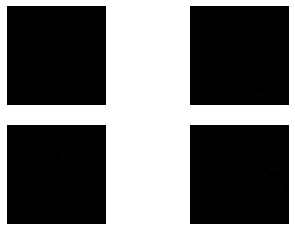

In [33]:
#example of fake image generator

samples = 4

x,_ = create_data_fake(MG,samples)

for i in range(samples):
  plt.subplot(2,2,1+i)
  plt.axis('off')
  plt.imshow(x[i])

#generated image shape
print(x[0].shape)

In [34]:
from keras.optimizers import Adam


In [35]:
def discriminator_model():
  d= MK.Sequential()

  d.add(LK.Conv2D(64, kernel_size=3, padding='same',input_shape=(32,32,3)))
  d.add(LK.LeakyReLU(alpha=0.2))

  d.add(LK.Conv2D(128, kernel_size=3,strides=(2,2), padding='same'))
  d.add(LK.LeakyReLU(alpha=0.2))

  d.add(LK.Conv2D(128, kernel_size=3,strides=(2,2), padding='same'))
  d.add(LK.LeakyReLU(alpha=0.2))

  d.add(LK.Conv2D(256, kernel_size=3,strides=(2,2), padding='same'))
  d.add(LK.LeakyReLU(alpha=0.2))

  d.add(LK.Flatten())
  d.add(LK.Dropout(0.4))

  d.add(LK.Dense(1,activation='sigmoid'))

  opt = Adam(lr=0.0002,beta_1=0.5)
  d.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

  return d

MD = discriminator_model()
MD.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)        

In [36]:
from keras.datasets import cifar10

In [37]:
(x_train,  y_train),(_,_) = cifar10.load_data()

indice = np.where(y_train == 1)

indice = indice[0]


x_train = x_train[indice, :,:,:]

x_data = x_train.astype('float32')
x_data = (x_data - 127.5)/127.5

print(x_data.shape)

(5000, 32, 32, 3)


In [38]:
# pretrain discriminator model
def load_data_real(dataset, samples):
  ix = np.random.randint(0, dataset.shape[0], samples)
  x = dataset[ix]
  y = np.ones((samples, 1))
  return x, y

def load_data_fake(samples):
  x = np.random.rand(32 * 32 * 3 * samples)
  x = -1 + x*2 # Offset de -1
  x = x.reshape((samples, 32, 32, 3))
  y = np.zeros((samples, 1))
  return x, y

def train_d(model, dataset, n_iter = 20, batch = 120):
  m_batch = int(batch / 2)
  for i in range(n_iter):
    x_real, y_real = load_data_real(dataset, m_batch)
    _, acc_real = model.train_on_batch(x_real, y_real)

    x_fake, y_fake = load_data_fake(m_batch)
    _, acc_fake = model.train_on_batch(x_fake, y_fake)

    print(str(i + 1) + ' Accuracy real images:' + str(acc_real * 100), 'Accuracy fake images:' + str(acc_fake * 100))

In [39]:
dataset = x_data

train_d(MD, dataset)

1 Accuracy real images:13.333334028720856 Accuracy fake images:6.666667014360428
2 Accuracy real images:94.9999988079071 Accuracy fake images:18.333333730697632
3 Accuracy real images:91.66666865348816 Accuracy fake images:46.666666865348816
4 Accuracy real images:88.33333253860474 Accuracy fake images:78.33333611488342
5 Accuracy real images:80.0000011920929 Accuracy fake images:88.33333253860474
6 Accuracy real images:89.99999761581421 Accuracy fake images:98.33333492279053
7 Accuracy real images:91.66666865348816 Accuracy fake images:100.0
8 Accuracy real images:96.66666388511658 Accuracy fake images:100.0
9 Accuracy real images:93.33333373069763 Accuracy fake images:100.0
10 Accuracy real images:88.33333253860474 Accuracy fake images:100.0
11 Accuracy real images:85.00000238418579 Accuracy fake images:100.0
12 Accuracy real images:86.66666746139526 Accuracy fake images:100.0
13 Accuracy real images:91.66666865348816 Accuracy fake images:100.0
14 Accuracy real images:94.999998807907

In [40]:
#GAN

def create_gan(md,mg):
  md.trainable = False
  gan = MK.Sequential()
  
  gan.add(mg)
  gan.add(md)

  opt = Adam(lr=0.0002,beta_1=0.5)
  gan.compile(loss= 'binary_crossentropy', optimizer = opt)

  return gan

gan = create_gan(MD, MG)
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 32, 32, 3)         1007363   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 522497    
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


## Save generated images

In [41]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
from datetime import datetime 

def show_gen_imgs(data_fake, epoch): 
  now = datetime.now() 
  now = now.strftime("%Y%m%d_%H%M%S") 
  # normalize 0 and 1 
  data_fake = (data_fake + 1) / 2.0 
  for i in range(1): 
    plt.imshow(data_fake[i]) 
    plt.axis('off') 
    name_img = str(epoch) + '_gen_img_' + str(i) + '.png' 
    plt.savefig(name_img, bbox_inches='tight') 
    plt.close()

In [42]:
def eval_and_save(mg, epoch, half_dataset): 
  # We save the model 
  now = datetime.now() 
  now = now.strftime("%Y%m%d_%H%M%S") 
  GANM = str(epoch) + '_' + str(now)+"_model_generator_" + '.h5' 
  mg.save(GANM) 
  # We generate new data 
  X_real,Y_real = load_data_real(dataset, half_dataset) 
  X_fake, Y_fake = create_data_fake(mg,half_dataset) 
  # We evaluate the model 
  _, acc_real = MD.evaluate(X_real, Y_real) 
  _, acc_fake = MD.evaluate(X_fake, Y_fake) 
  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [43]:
def train(data, mg, md, epochs, n_batch, ini = 0): 
  dimension_batch = int(data.shape[0]/n_batch) 
  half_dataset = int(n_batch/2) 
  # We iterate over the epochs 
  for epoch in range(ini, ini + epochs): 
    # We iterate over all batches 
    for batch in range(n_batch): 
      # We load all the real data 
      X_real,Y_real = load_data_real(dataset, half_dataset) 

      # We train the discriminator with real data 
      coste_discriminador_real, _ = md.train_on_batch(X_real, Y_real) 
      X_fake, Y_fake = create_data_fake(mg,half_dataset) 
      coste_discriminador_fake, _ = md.train_on_batch(X_fake, Y_fake) 

      # We generate input images for the GAN 
      X_gan = generate_input_data(half_dataset) 
      Y_gan = np.ones((half_dataset, 1)) 

      # We train the GAN with fake data 
      coste_gan = gan.train_on_batch(X_gan, Y_gan) 

      # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      eval_and_save(mg,epoch = epoch, half_dataset= half_dataset) 
      show_gen_imgs(X_fake, epoch = epoch)

In [45]:
train(dataset,MG,MD,epochs=300,n_batch=128,ini=0)

2/2 [==============================] - 0s 7ms/step - loss: 0.2371 - accuracy: 0.9844
Acc Real:79.6875% Acc Fake:98.4375%
2/2 [==============================] - 0s 7ms/step - loss: 0.4013 - accuracy: 0.9062
Acc Real:76.5625% Acc Fake:90.625%
2/2 [==============================] - 0s 8ms/step - loss: 0.3992 - accuracy: 0.9062
Acc Real:65.625% Acc Fake:90.625%
2/2 [==============================] - 0s 8ms/step - loss: 0.4631 - accuracy: 0.8750
Acc Real:68.75% Acc Fake:87.5%
2/2 [==============================] - 0s 9ms/step - loss: 0.3824 - accuracy: 0.8906
Acc Real:75.0% Acc Fake:89.0625%
2/2 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 0.9688
Acc Real:79.6875% Acc Fake:96.875%
2/2 [==============================] - 0s 7ms/step - loss: 0.3732 - accuracy: 0.9375
Acc Real:76.5625% Acc Fake:93.75%
2/2 [==============================] - 0s 5ms/step - loss: 0.3430 - accuracy: 0.9375
Acc Real:85.9375% Acc Fake:93.75%
2/2 [==============================] - 0s 6ms/st

In [46]:
!mkdir -p "/content/inference_img_gen"

In [47]:
%cd /content/inference_img_gen

/content/inference_img_gen


In [48]:
import cv2
x_fake, _ = create_data_fake(samples=10, model_generator=MG)
x_fake = (x_fake+1)/2

print('inference - generated images:')
for i in range(10):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(x_fake[i])
  
  # hide these lines if you don't want to save the generated images
  name_img = 'inf_gen_img_' + str(i) + '.png'
  plt.savefig(name_img, bbox_inches='tight') 
  plt.close()  




inference - generated images:
